Import libraries

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

2025-01-21 15:49:17.105267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 15:49:17.136561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 15:49:17.146417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 15:49:17.171121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 15:49:18.290396: W tensorflow/compiler/tf2

Set the input paths and parameters

In [2]:
train_input_path = "/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train/image"
train_mask_path = "/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train/mask"
test_input_path = "/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/test/image"
test_mask_path = "/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/test/mask"
model_path = "/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/models"

Get the paths of the images and masks

In [3]:
train_input_paths = [os.path.join(train_input_path, path) for path in os.listdir(train_input_path) if path.endswith(".tif")]
train_mask_paths = [os.path.join(train_mask_path, path) for path in os.listdir(train_mask_path) if path.endswith(".tif")]
print("Input images: " + str(len(train_input_paths)))
print("Input masks: " + str(len(train_mask_paths)))
print("---")
test_input_paths = [os.path.join(test_input_path, path) for path in os.listdir(test_input_path) if path.endswith(".tif")]
test_mask_paths = [os.path.join(test_mask_path, path) for path in os.listdir(test_mask_path) if path.endswith(".tif")]
print("Test images: " + str(len(test_input_paths)))
print("Test masks: " + str(len(test_mask_paths)))
train_path_dataset = tf.data.Dataset.from_tensor_slices((train_input_paths, train_mask_paths))
test_path_dataset = tf.data.Dataset.from_tensor_slices((test_input_paths, test_mask_paths))

Input images: 10358
Input masks: 10358
---
Test images: 2590
Test masks: 2590


2025-01-21 15:49:22.165069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13027 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:03:00.0, compute capability: 7.5


In [4]:
for pair in train_path_dataset.take(1):
    print(pair)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train/image/T 5 t_8\xc2\xb5m_x50_r0011_c0020.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train/mask/T 5 t_8\xc2\xb5m_x50_r0011_c0020.tif'>)


2025-01-21 15:49:23.475401: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We define a function to read image/mask pairs.

In [5]:
def read_images(img_path, segmentation_mask_path):
    img_data = tf.io.read_file(img_path)
    img = tfio.experimental.image.decode_tiff(img_data)
    segm_data = tf.io.read_file(segmentation_mask_path)
    segm_mask = tfio.experimental.image.decode_tiff(segm_data)
    
    return img, segm_mask

Normalize images and masks.

In [6]:
def prepare_images(img, semg_mask):
    # img = tfio.experimental.color.rgba_to_rgb(img)
    img = tf.image.convert_image_dtype(img, "float32")
    semg_mask = semg_mask / 255
    return img, semg_mask

We create a dataset containing pairs of images/masks.

In [7]:
train_dataset = train_path_dataset.map(read_images, num_parallel_calls=tf.data.AUTOTUNE).map(prepare_images, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_path_dataset.map(read_images, num_parallel_calls=tf.data.AUTOTUNE).map(prepare_images, num_parallel_calls=tf.data.AUTOTUNE)

2025-01-21 15:49:28.892970: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


Build train and validation batches.

In [26]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
VALIDATION_SIZE = int(round((len(train_dataset) * 20) / 100))
print("validation data size: " + str(VALIDATION_SIZE))
print("train data size: " + str(len(train_dataset) - VALIDATION_SIZE))
validation_batches = train_dataset.take(VALIDATION_SIZE).batch(BATCH_SIZE)
train_batches = train_dataset.skip(VALIDATION_SIZE)
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation data size: 2072
train data size: 8286


In [27]:
print(train_dataset.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None))>


Display some random examples of pairs of input tiles and mask tiles.

(256, 256, 4)
<class 'tensorflow.python.framework.ops.EagerTensor'>


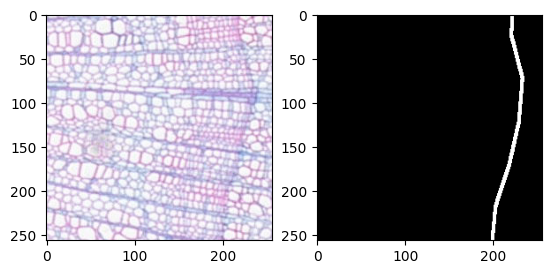

(256, 256, 4)
<class 'tensorflow.python.framework.ops.EagerTensor'>


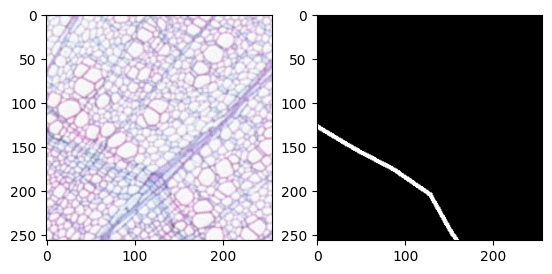

(256, 256, 4)
<class 'tensorflow.python.framework.ops.EagerTensor'>


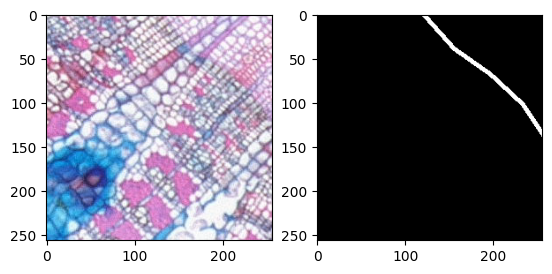

In [28]:
import matplotlib.pyplot as plt
N = 3
for image, mask in train_dataset.shuffle(len(train_dataset)).take(N):
    print(image.shape)
    print(type(image))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax2.imshow(mask)
    plt.show()

Building blocks for the UNet.

In [29]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

Function that builds the UNet

In [30]:
def build_unet_model():
   inputs = layers.Input(shape=(256,256,4))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(4, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model    

Build the UNet.

In [31]:
unet_model = build_unet_model()

In [32]:
keras.utils.plot_model(unet_model, show_shapes=True)
"model.png written"

'model.png written'

Compile the model.

In [33]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_focal_crossentropy",
                  metrics=["accuracy"])

In [34]:
NUM_EPOCHS = 20

STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
VAL_SUBSPLITS = 5
VAL_LENGTH = VALIDATION_SIZE
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=validation_batches,
                              verbose=2
                              )

Epoch 1/20


2025-01-21 15:54:53.179777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
E0000 00:00:1737471320.811203 2063055 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-21 15:55:21.184116: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue

323/323 - 378s - 1s/step - accuracy: 0.9823 - loss: 0.0298 - val_accuracy: 0.9849 - val_loss: 0.0146
Epoch 2/20


E0000 00:00:1737471686.548249 2063058 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737471686.921918 2063058 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-01-21 16:01:26.960333: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[22,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E0000 00:00:1

323/323 - 341s - 1s/step - accuracy: 0.9852 - loss: 0.0140 - val_accuracy: 0.9853 - val_loss: 0.0128
Epoch 3/20
323/323 - 284s - 879ms/step - accuracy: 0.9852 - loss: 0.0122 - val_accuracy: 0.9858 - val_loss: 0.0107
Epoch 4/20
323/323 - 287s - 890ms/step - accuracy: 0.9852 - loss: 0.0105 - val_accuracy: 0.9849 - val_loss: 0.0094
Epoch 5/20
323/323 - 288s - 892ms/step - accuracy: 0.9852 - loss: 0.0094 - val_accuracy: 0.9852 - val_loss: 0.0085
Epoch 6/20
323/323 - 300s - 930ms/step - accuracy: 0.9852 - loss: 0.0086 - val_accuracy: 0.9848 - val_loss: 0.0077
Epoch 7/20


2025-01-21 16:26:10.549355: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-21 16:26:10.549434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7256344073917436037
2025-01-21 16:26:10.549483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4831764059890949892
/home/baecker/miniforge3/envs/tf-gpu/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


323/323 - 286s - 887ms/step - accuracy: 0.9852 - loss: 0.0080 - val_accuracy: 0.9849 - val_loss: 0.0079
Epoch 8/20
323/323 - 287s - 888ms/step - accuracy: 0.9852 - loss: 0.0079 - val_accuracy: 0.9853 - val_loss: 0.0071
Epoch 9/20
323/323 - 283s - 877ms/step - accuracy: 0.9852 - loss: 0.0076 - val_accuracy: 0.9858 - val_loss: 0.0072
Epoch 10/20
323/323 - 285s - 881ms/step - accuracy: 0.9852 - loss: 0.0074 - val_accuracy: 0.9849 - val_loss: 0.0071
Epoch 11/20
323/323 - 284s - 880ms/step - accuracy: 0.9852 - loss: 0.0073 - val_accuracy: 0.9852 - val_loss: 0.0072
Epoch 12/20
323/323 - 283s - 876ms/step - accuracy: 0.9852 - loss: 0.0071 - val_accuracy: 0.9848 - val_loss: 0.0068
Epoch 13/20
323/323 - 287s - 888ms/step - accuracy: 0.9852 - loss: 0.0070 - val_accuracy: 0.9849 - val_loss: 0.0068
Epoch 14/20
323/323 - 280s - 867ms/step - accuracy: 0.9852 - loss: 0.0069 - val_accuracy: 0.9853 - val_loss: 0.0064
Epoch 15/20
323/323 - 280s - 866ms/step - accuracy: 0.9851 - loss: 0.0069 - val_accura

2025-01-21 17:22:54.835249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7256344073917436037
2025-01-21 17:22:54.835350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4831764059890949892


323/323 - 284s - 879ms/step - accuracy: 0.9852 - loss: 0.0065 - val_accuracy: 0.9849 - val_loss: 0.0066
Epoch 20/20
323/323 - 280s - 866ms/step - accuracy: 0.9851 - loss: 0.0064 - val_accuracy: 0.9853 - val_loss: 0.0060


In [35]:
import datetime
date = datetime.datetime.now()
unet_model.save(os.path.join(model_path, "./unet - " + str(date) + ".keras"))

In [36]:
print(model_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


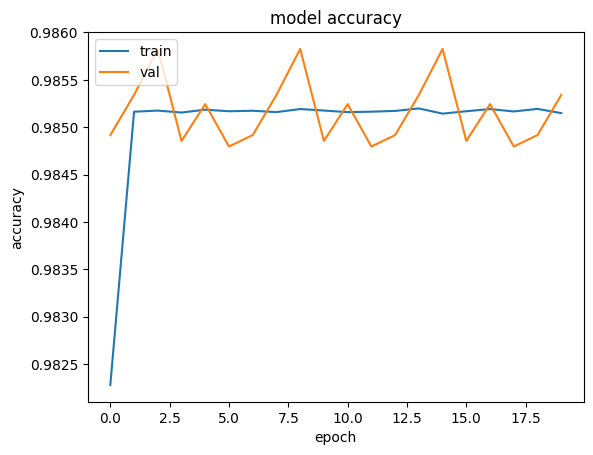

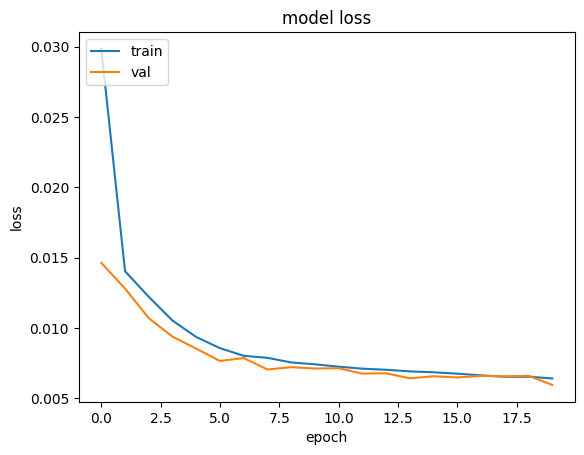

In [38]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load a saved model

In [ ]:
model = "unet - 2025-01-21 15:25:42.372171.keras"
path = os.path.join(model_path, model)
unet_model = keras.models.load_model(path)

Evaluate model on test data.

In [40]:
test_batches = train_dataset.take(len(test_dataset)).batch(BATCH_SIZE)
score = unet_model.evaluate(test_batches, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

E0000 00:00:1737477480.901331 2063055 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737477481.081925 2063055 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737477482.294472 2063055 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737477482.533656 2063055 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Test loss: 0.006083450745791197
Test accuracy: 0.9851616024971008


Apply the model to an image.